In [1]:
import numpy as np
import pandas as pd
import os
import glob
import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase
import seaborn as sns

from nilearn import plotting 
from nilearn.image import smooth_img, swap_img_hemispheres

from nilearn.input_data import NiftiMasker
import nibabel as nib

import scipy.stats
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_1samp
import statsmodels.api as sm

import llms_brain_lateralization as lbl
from llms_brain_lateralization import make_dir

In [2]:
#configuración de figuras
rc={'font.size': 12, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('darkgrid')
save_fig = True
if save_fig:
    fig_folder = lbl.figures_folder
    make_dir(fig_folder)

class MyLegendHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        lines = []
        n_models = len(color_models[::8])
        for i, color in enumerate(color_models[::8]):
             lines.append(plt.Line2D([x0,y0+width], 
                               [i/n_models*height,i/n_models*height], 
                               color=color))
        return lines


#paleta de colores
l_r_colors = sns.color_palette('colorblind', n_colors=4)[2:][::-1]

#cargar la máscara
nifti_masker = NiftiMasker(mask_img='mask_lpp_en.nii.gz')
nifti_masker.fit()
n_voxels = nifti_masker.n_elements_

#carpeta donde están las correlaciones
glm_folder = './llms_brain_correlations'#lbl.llms_brain_correlations

def plot_xy(xvalue, yvalue, xlabel=None, ylabel=None, logx=False, invert_xaxis=False, figsize=(6.4, 4.8)):        
    fh = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    sns.regplot(x=xvalue,
                y=yvalue,
                logx=logx, ax=ax);
    if logx:
        ax.set_xscale('log')
    if invert_xaxis:
        ax.invert_xaxis()
    ax.set_xlabel(xlabel)      
    ax.set_ylabel(ylabel)
    if logx:
         r, p = pearsonr(np.log(xvalue), yvalue)
    else:
         r, p = pearsonr(xvalue, yvalue)
   
    fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
            ha='left', va='top', fontsize=11)
    return fh

# poner asteriscos a p-valores
def pvalue2str(pvalue):
    if pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return 'ns'

## Confiabilidad de los vóxeles

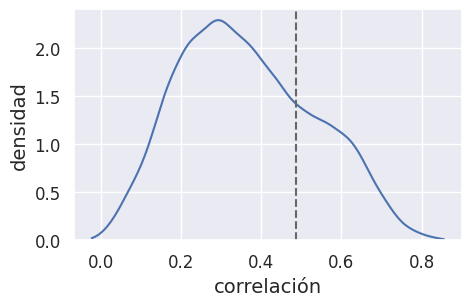

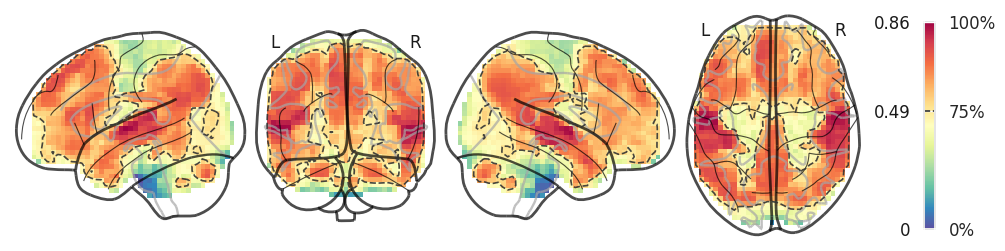

In [3]:
n_trials_split = 10
filename = 'corr_group_split_{}trials.gz'.format(n_trials_split)
corr_split = joblib.load(filename)
corr_split_mean = np.mean(corr_split, axis=0)

#indicador de vóxeles confiables (por encima del percnetil 75)
is_voxel_reliable = corr_split_mean > np.percentile(corr_split_mean, 75)

fh = plt.figure(figsize=(5,3))
ax = plt.subplot(111)
sns.kdeplot(corr_split_mean, cut=0., ax=ax)
plt.axvline(np.percentile(corr_split_mean, 75), ls='--', c='0.4');
plt.xlabel('correlación')
plt.ylabel('densidad')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_distribution.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

imgtmp = nifti_masker.inverse_transform(corr_split_mean)
fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
display = plotting.plot_glass_brain(imgtmp, threshold=0., display_mode='lyrz', 
                          vmin=0., cmap='Spectral_r', 
                          plot_abs=True, colorbar=True, axes=ax)
display.add_contours(imgtmp, levels=[np.percentile(corr_split_mean, 75)], colors='0.2', linewidths=1.2, alpha=0.9, linestyles='dashed')
display._colorbar_ax.set_yticks([0., np.percentile(corr_split_mean, 75), np.max(corr_split_mean)])
ylim = display._colorbar_ax.get_ylim()  
ax2 = display._colorbar_ax.twinx()
ax2.set_ylim(ylim)
ax2.set_yticks([0., np.percentile(corr_split_mean, 75), np.max(corr_split_mean)], ['0%', '75%', '100%'])
ax2.yaxis.set_tick_params(width=0)
#display._cbar._
ax2.axhline(np.percentile(corr_split_mean, 75), ls='--', lw=1.2, color='0.2')

plotting.show() 

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_75.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

## Modelos nulos y modelo de word embedding

In [4]:
# Vectores random de tamaño 300
corr_random_300 = []
model_name ='random_vector_300d_seed1'
filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
with open(filename, 'rb') as f:
    corr_random_300 = joblib.load(f)


# Random embedding de tamaño 300
corr_random_emb_300 = []
model_name ='random_embedding_300d_seed1'
filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
with open(filename, 'rb') as f:
    corr_random_emb_300 = joblib.load(f)

# Random embedding de tamaño 1024
corr_random_emb_1024 = []
model_name ='random_embedding_1024d_seed1'
filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
with open(filename, 'rb') as f:
    corr_random_emb_1024 = joblib.load(f)

# Word embedding basado en asociación libre (SWOW)
corr_swow = []
model_name ='swow'
filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
with open(filename, 'rb') as f:
    corr_swow = joblib.load(f)


### Distribución de valores de correlación

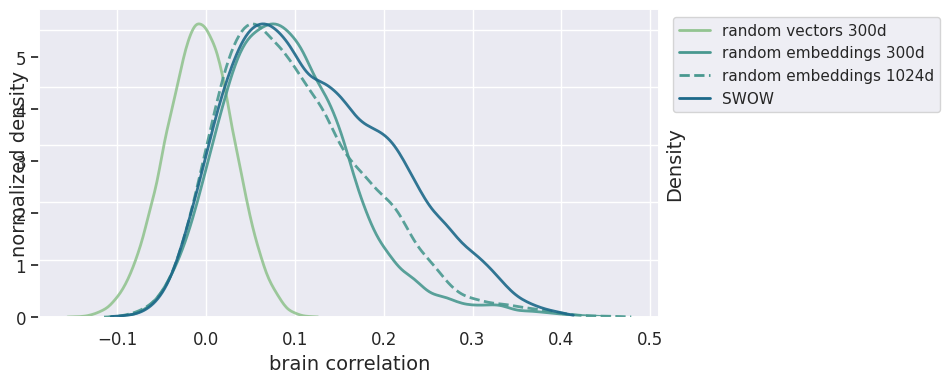

In [5]:
color_baseline = sns.color_palette('crest', n_colors=15)[::5]


fh = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
sns.kdeplot(corr_random_300, c=color_baseline[0], lw=2, alpha=0.9, cut=0., ax=ax);
#ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
plt.xlabel('brain correlation')
plt.ylabel('normalized density')
ax = plt.twinx()
ax.grid(None)
sns.kdeplot(corr_random_emb_300, c=color_baseline[1], lw=2, alpha=0.9, cut=0.);
ax = plt.twinx()
ax.axis('off')
ax.grid(None)
sns.kdeplot(corr_random_emb_1024, c=color_baseline[1], ls='--', lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_swow, c=color_baseline[2], lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')

plt.plot([0], c=color_baseline[0], lw=2, label='random vectors 300d')
plt.plot([0], c=color_baseline[1], lw=2, label='random embeddings 300d')
plt.plot([0], c=color_baseline[1], lw=2, ls='--', label='random embeddings 1024d')
plt.plot([0], c=color_baseline[2], lw=2, label='SWOW')

#hllm, = plt.plot([0], label='28 large language models')

hllm, = plt.plot([0])

ax.tick_params(axis='y', labelleft='off')

plt.legend(handler_map={hllm: MyLegendHandler()}, bbox_to_anchor=(1.01,1), loc='upper left')

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'distribution_correlation_models_baselines.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

### Distribución de valores de correlación - únicamente vóxeles consistentes

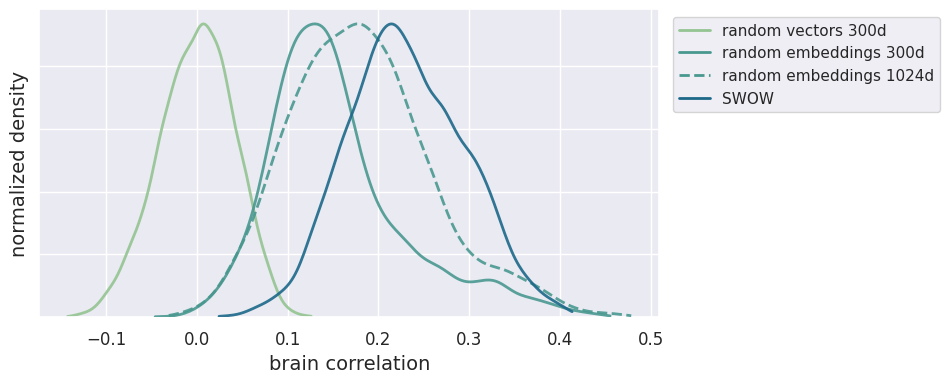

In [6]:
color_baseline = sns.color_palette('crest', n_colors=15)[::5]


fh = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
sns.kdeplot(corr_random_300[is_voxel_reliable], c=color_baseline[0], lw=2, alpha=0.9, cut=0., ax=ax);
#ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
plt.xlabel('brain correlation')
plt.ylabel('normalized density')
ax = plt.twinx()
ax.grid(None)
ax.axis('off')
sns.kdeplot(corr_random_emb_300[is_voxel_reliable], c=color_baseline[1], lw=2, alpha=0.9, cut=0.);
ax = plt.twinx()
ax.axis('off')
ax.grid(None)
sns.kdeplot(corr_random_emb_1024[is_voxel_reliable], c=color_baseline[1], ls='--', lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_swow[is_voxel_reliable], c=color_baseline[2], lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')

plt.plot([0], c=color_baseline[0], lw=2, label='random vectors 300d')
plt.plot([0], c=color_baseline[1], lw=2, label='random embeddings 300d')
plt.plot([0], c=color_baseline[1], lw=2, ls='--', label='random embeddings 1024d')
plt.plot([0], c=color_baseline[2], lw=2, label='SWOW')

#hllm, = plt.plot([0], label='28 large language models')

hllm, = plt.plot([0])

ax.tick_params(axis='y', labelleft='off')

plt.legend(handler_map={hllm: MyLegendHandler()}, bbox_to_anchor=(1.01,1), loc='upper left')

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'distribution_correlation_models_baselines.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

### Mapa topográfico de correlaciones

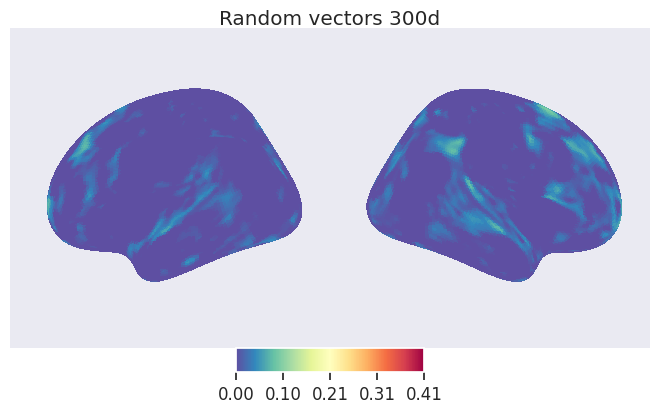

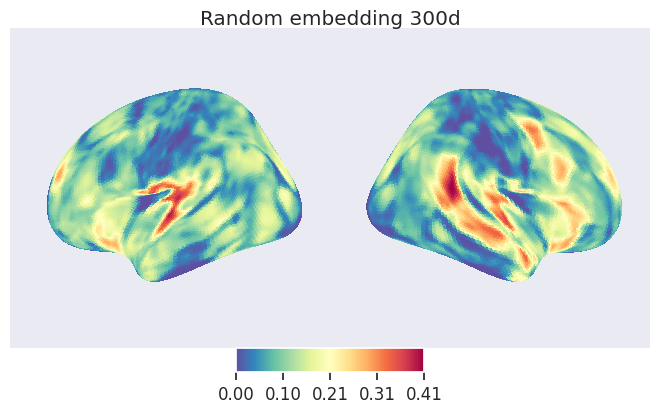

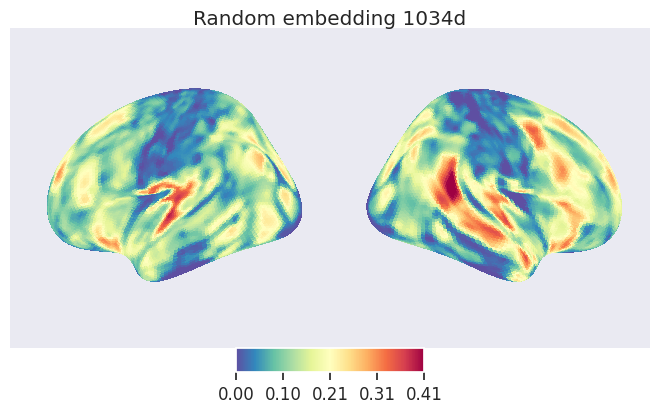

In [7]:
vmax = np.max(corr_swow)


imgtmp = nifti_masker.inverse_transform(corr_random_300)

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='Random vectors 300d')




imgtmp = nifti_masker.inverse_transform(corr_random_emb_300)

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='Random embedding 300d')

imgtmp = nifti_masker.inverse_transform(corr_random_emb_1024)




fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='Random embedding 1034d')




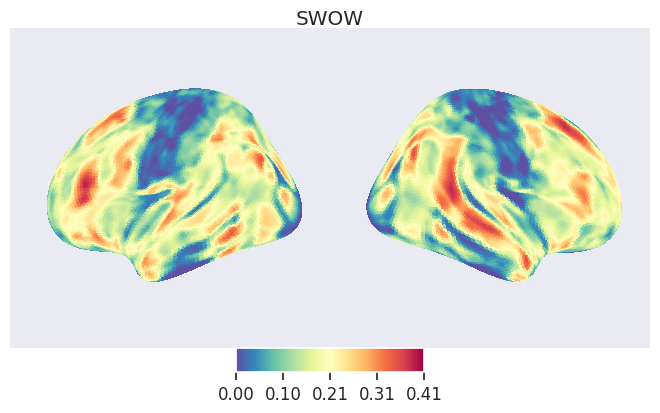

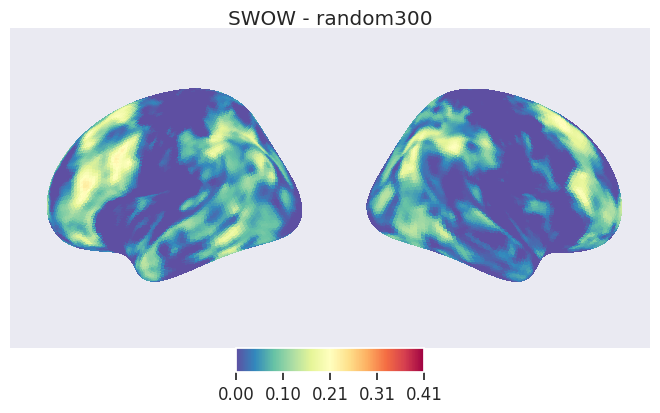

In [8]:

imgtmp = nifti_masker.inverse_transform(corr_swow)


fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='SWOW')

imgtmp = nifti_masker.inverse_transform(corr_swow-corr_random_emb_300)
#vmax = np.max(corr_swow)

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='SWOW - random300')


## Modelos de la familia Qwen2.5 0.5B

In [10]:
model_names=['Qwen2.5-0.5B','Qwen2.5-7B','Qwen2.5-32B']
n_layers_models = [24,28,64]
n_models = len(model_names)
n_parameters = [0.5, 7,32]

corr_layers_voxels_models = []
for model_name, n_layers in zip(model_names, n_layers_models):
    corr_layers_voxels = []
    for idx_layer in range(n_layers):
        filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, idx_layer))
        with open(filename, 'rb') as f:
            corr_voxels = joblib.load(f)
        corr_layers_voxels.append(corr_voxels)
    corr_layers_voxels_models.append(np.array(corr_layers_voxels))


color_models = list(sns.color_palette('plasma', n_colors=len(corr_layers_voxels_models)))

# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models = np.array([np.max(corr_layers_voxels, axis=0) for corr_layers_voxels in corr_layers_voxels_models])

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models = np.array([np.mean(corr_voxels) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models = [np.mean(corr_layers, axis=1) for corr_layers in corr_layers_voxels_models]

# restrict to left and right hemisphere
corr_l_models = corr_voxels_models[:,:n_voxels//2]
corr_r_models = corr_voxels_models[:,n_voxels//2:]

### Restringiendo a vóxeles confiables

In [11]:
corr_voxels_models_rv = np.array([np.max(corr_layers_voxels[:,is_voxel_reliable], axis=0)
                                  for corr_layers_voxels in corr_layers_voxels_models])

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models_rv = np.array([np.mean(corr_voxels[is_voxel_reliable]) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models_rv = [np.mean(corr_layers[:, is_voxel_reliable], axis=1) for corr_layers in corr_layers_voxels_models]

# restrict to left and right hemisphere
# n_models x n_voxels//2
corr_l_models_rv = corr_l_models[:,is_voxel_reliable[:n_voxels//2]]
corr_r_models_rv = corr_r_models[:,is_voxel_reliable[n_voxels//2:]]

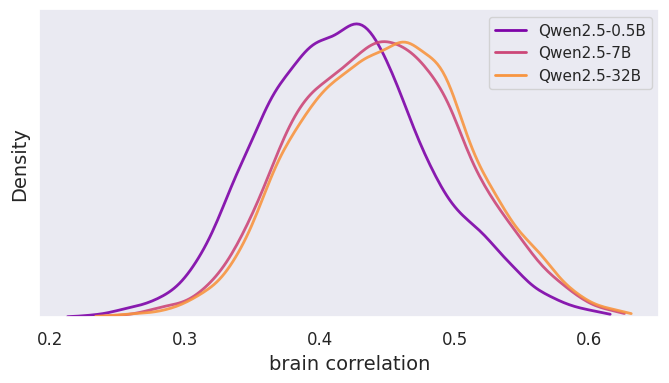

In [51]:
fh, ax = plt.subplots(figsize=(8, 4))

for i, corrs in enumerate(corr_voxels_models_rv):
    sns.kdeplot(corrs, lw=2, alpha=0.9, cut=0., ax=ax, color=color_models[i])
    ax.plot([], c=color_models[i], lw=2, label=model_names[i])  # Empty plot to add legend entry

ax.set_xlabel('brain correlation')
ax.legend()
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
ax.grid(None)



#ax.set_yticks([])



In [44]:
color_models

[(0.494877, 0.01199, 0.657865),
 (0.798216, 0.280197, 0.469538),
 (0.973416, 0.585761, 0.25154)]

In [46]:
len(corr_voxels_models)

3

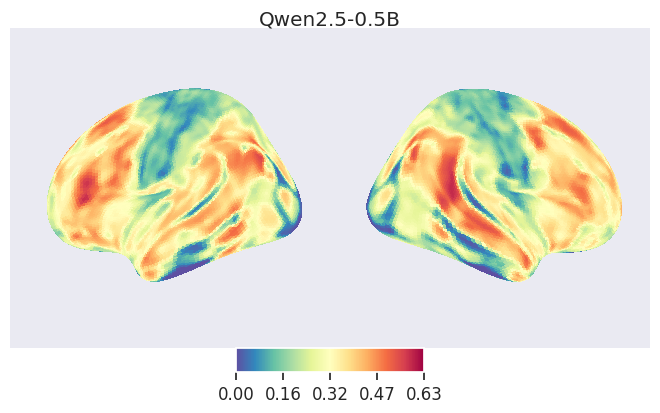

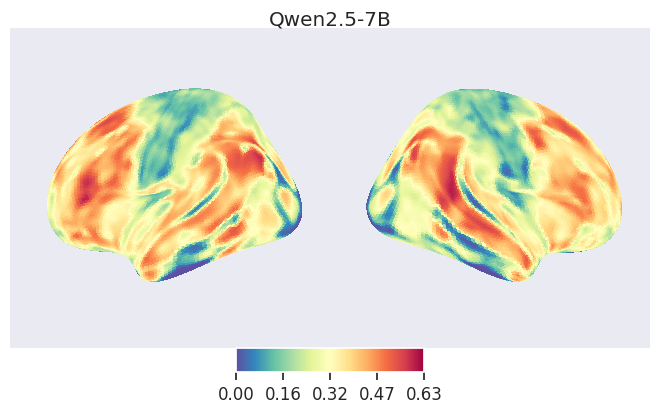

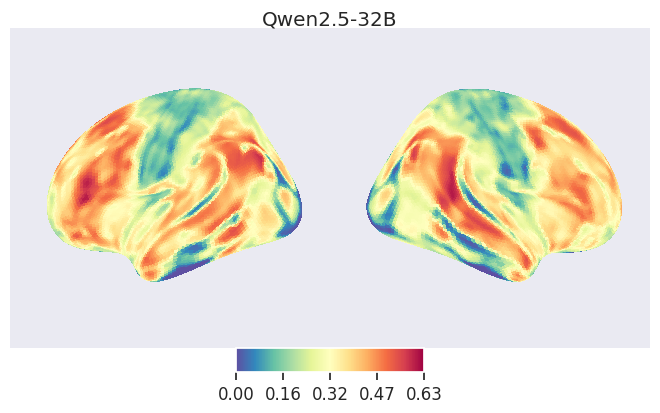

In [66]:

imgtmp = nifti_masker.inverse_transform(corr_voxels_models[0])
vmax = np.max(corr_voxels_models[2])

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='Qwen2.5-0.5B')



imgtmp = nifti_masker.inverse_transform(corr_voxels_models[1])

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='Qwen2.5-7B')


imgtmp = nifti_masker.inverse_transform(corr_voxels_models[2])

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     inflate=True,
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='Qwen2.5-32B')

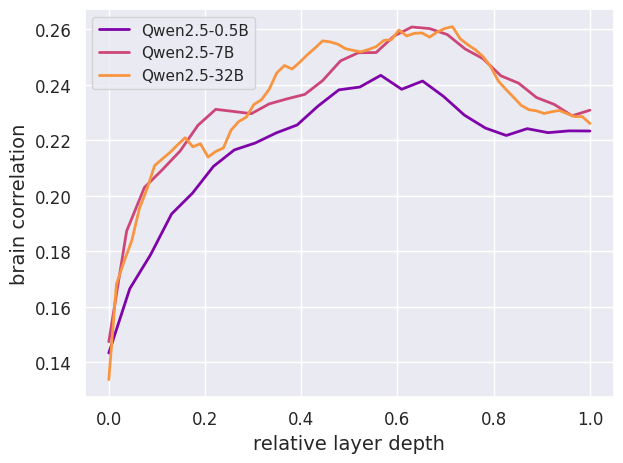

In [53]:
# Set up figure and axis
fh, ax = plt.subplots(figsize=(6.4, 4.8))

# Loop through each model layer and its corresponding correlation data
for i, (n_layers, corr_layers) in enumerate(zip(n_layers_models, corr_layers_models)):
    ax.plot(np.linspace(0, 1, n_layers), corr_layers, 
            lw=2, ls='-', color=color_models[i], label=model_names[i])

# Set labels
ax.set_ylabel('brain correlation')
ax.set_xlabel('relative layer depth')

# Add legend
ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



array([[ 0.26731655,  0.25735109,  0.27031556, ...,  0.08364174,
         0.00805598, -0.05918235],
       [ 0.2941346 ,  0.27337048,  0.2718462 , ...,  0.08042484,
         0.02795934, -0.06891694],
       [ 0.3290733 ,  0.30870465,  0.29686541, ...,  0.06234239,
         0.02166563, -0.03244387],
       ...,
       [ 0.3976248 ,  0.39850216,  0.3817211 , ...,  0.09533596,
         0.05543408,  0.02435371],
       [ 0.39543309,  0.40201433,  0.38438274, ...,  0.10030641,
         0.06310754,  0.06237956],
       [ 0.39219574,  0.3962705 ,  0.38267933, ...,  0.09485885,
         0.06648002,  0.05971146]])